# Clustering analysis

## Use of DBSCAN

In [1]:
# Usual imports

from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

rnd_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

# the .py files with the functions provided must be in the same directory of the .ipynb file
from plot_clusters import plot_clusters      # python script provided separately

### 1. Load the data

In [2]:
data_file = 'ex1_4dim_data.csv'
delimiter = ','
X = np.loadtxt(data_file, delimiter = delimiter)

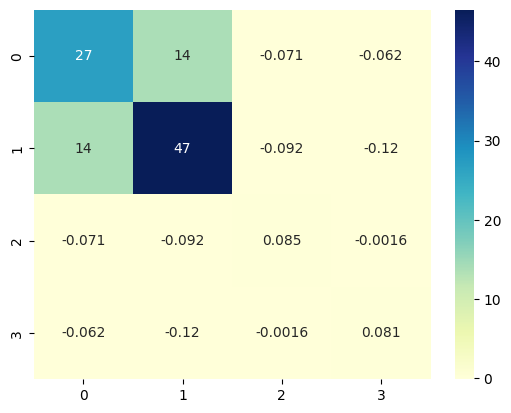

In [3]:
cov_mat = np.cov(X, rowvar = False) # occorre la trasposta
import seaborn as sns
sns.heatmap(cov_mat, cmap="YlGnBu", annot=True);

### 3. Inspect the dataset

In [4]:
X.shape

(1500, 4)

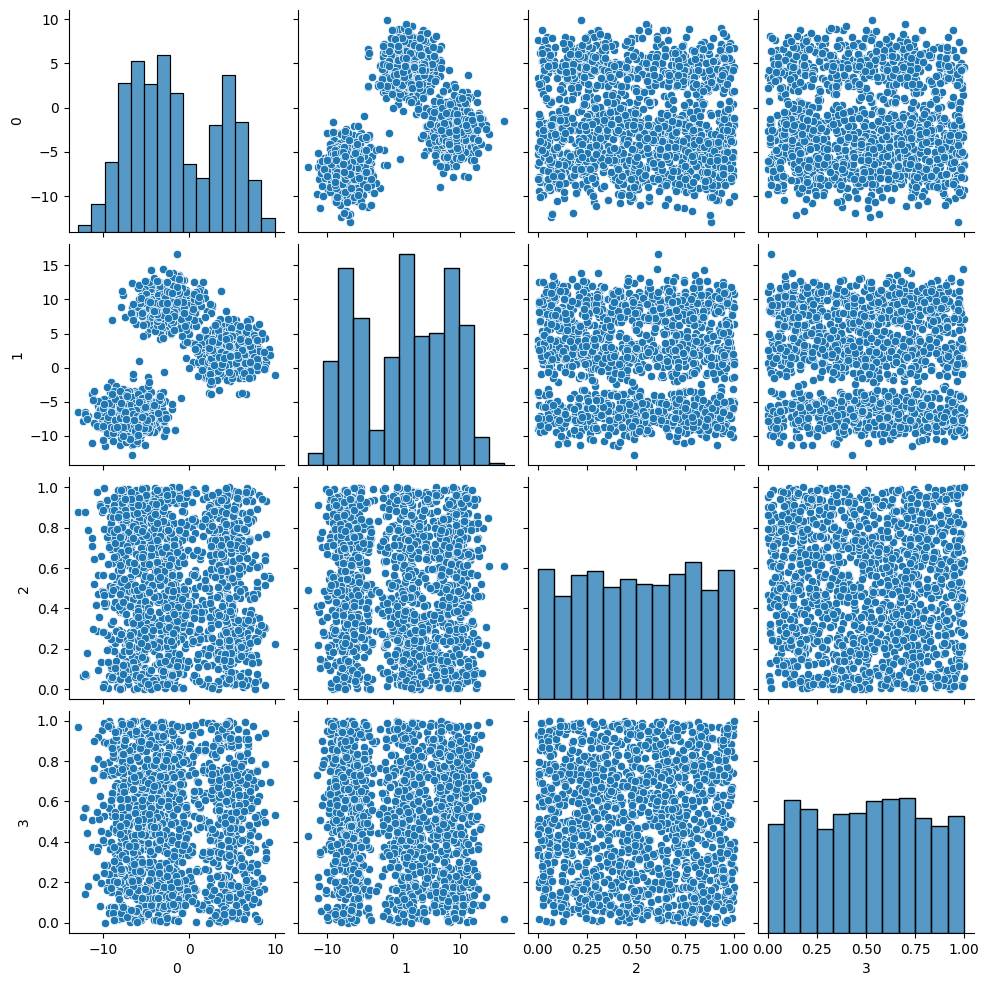

In [5]:
sns.pairplot(pd.DataFrame(X));

As we can see from the pairplot and, also, from the heatmap, columns 2 and 3 are not really interesting, so we should focus only on columns 0 and 1.

In [6]:
X = X[:,[0,1]]
focus = [0,1]

### 3. Observing the pairplots

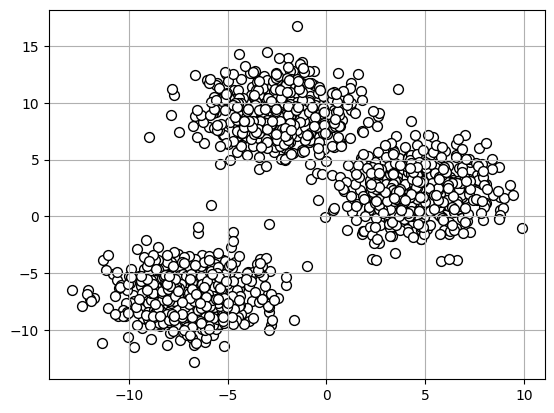

In [7]:
plt.scatter(X[:,focus[0]], X[:,focus[1]]
            , c='white'          # color filling the data markers
            , edgecolors='black' # edge color for data markers
            , marker='o'         # data marker shape, e.g. triangles (v<>^), square (s), star (*), ...
            , s=50)              # data marker size
plt.grid()  # plots a grid on the data
plt.show()

### 4. Initialize, fit_predict, plot_clusters

In [8]:
db = DBSCAN()
y_db = db.fit_predict(X)

In [9]:
db.eps, db.min_samples

(0.5, 5)

In [10]:
cluster_labels_all = np.unique(y_db)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)
if cluster_labels_all[0] == -1:
    noise = True
    print("There is noise")
else:
    noise = False
print("There is/are {} cluster(s)".format(n_clusters-noise))

There is noise
There is/are 11 cluster(s)


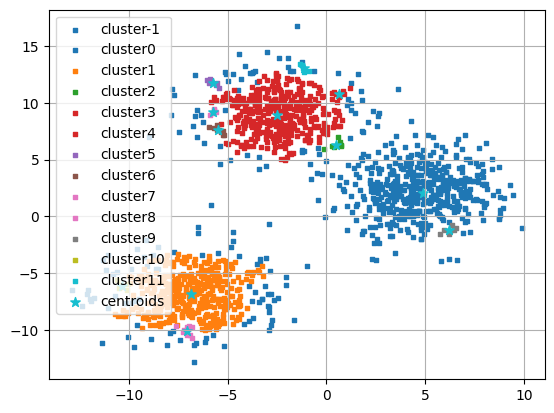

In [11]:
cluster_centers = np.empty((n_clusters,X.shape[1]))
for i in cluster_labels:
    cluster_centers[i,:] = np.mean(X[y_db==i,:], axis = 0)
plot_clusters(X,y_db,dim=(focus[0],focus[1]), points = cluster_centers)

### 5. Find the best parameters, using `ParameterGrid`

In [12]:
param_grid = {'eps': list(np.arange(0.01, 1, 0.01)), 'min_samples': list(range(1,10,1))}
params = list(ParameterGrid(param_grid))

Arrange DBSCAN results in a dataframe, for easier presentation and filtering

In [13]:
dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])
for i in range(len(params)):
    db = DBSCAN(**(params[i]))
    y_db = db.fit_predict(X)
    cluster_labels_all = np.unique(y_db)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters = len(cluster_labels)
    if n_clusters > 1:
        X_cl = X[y_db!=-1,:]
        y_db_cl = y_db[y_db!=-1]
        silhouette = silhouette_score(X_cl,y_db_cl)
        uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100
        dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]

In [14]:
sil_thr = 0.7  # visualize results only for combinations with silhouette above the threshold
unc_thr = 10 # visualize results only for combinations with unclustered% below the threshold
n_clu_max_thr = 4
dbscan_out[(dbscan_out['silhouette']>=sil_thr)\
         & (dbscan_out['unclust%']<=unc_thr)\
         & (dbscan_out['n_clusters']<=n_clu_max_thr)]

,eps,min_samples,n_clusters,silhouette,unclust%
542,0.72,6.0,3.0,0.719631,7.866667
551,0.73,6.0,3.0,0.719266,7.666667
560,0.74,6.0,3.0,0.719029,7.466667
569,0.75,6.0,3.0,0.718215,7.266667
578,0.76,6.0,3.0,0.717239,7.066667
...,...,...,...,...,...
778,0.98,8.0,3.0,0.708884,4.533333
779,0.98,9.0,3.0,0.709335,4.600000
786,0.99,7.0,3.0,0.705171,4.000000
787,0.99,8.0,3.0,0.707730,4.400000


### 6. Observe

Visual observation of the best parameters, clusters and their centers and the silhouette indexes.

In [16]:
db = DBSCAN(eps=0.99, min_samples=9)

y_db = db.fit_predict(X)
cluster_labels_all = np.unique(y_db)
cluster_labels = cluster_labels_all[cluster_labels_all != -1]
n_clusters = len(cluster_labels)

In [19]:
cluster_centers = np.empty((n_clusters,X.shape[1]))
for i in cluster_labels:
    cluster_centers[i,:] = np.mean(X[y_db==i,:], axis = 0)

In [25]:
print("There are {} clusters".format(n_clusters))

There are 3 clusters


In [26]:
print("The cluster labels are {}".format(cluster_labels))

The cluster labels are [0 1 2]


In [30]:
print(f'The coordinates of the centroids of the three clusters are:\n{cluster_centers}')

The coordinates of the centroids of the three clusters are:
[[ 4.78930786  2.14109441]
 [-6.83323668 -6.86794936]
 [-2.516712    9.09414398]]


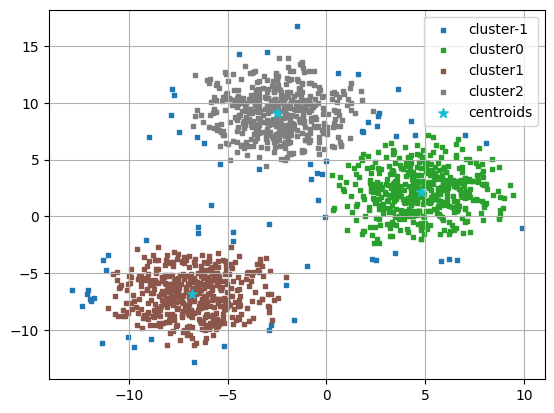

In [31]:
plot_clusters(X,y_db,dim=(focus[0],focus[1]), points = cluster_centers)

We can still see how the noise is present, looking at the `cluster -1`.

Compute the Silhouette Coefficient for each sample, with `silhouette_samples()`.

The Silhouette Coefficient is a measure of how well samples are clustered with samples that are similar to themselves. Clustering models with a high Silhouette Coefficient are said to be dense, where samples in the same cluster are similar to each other, and well separated, where samples in different clusters are not very similar to each other.

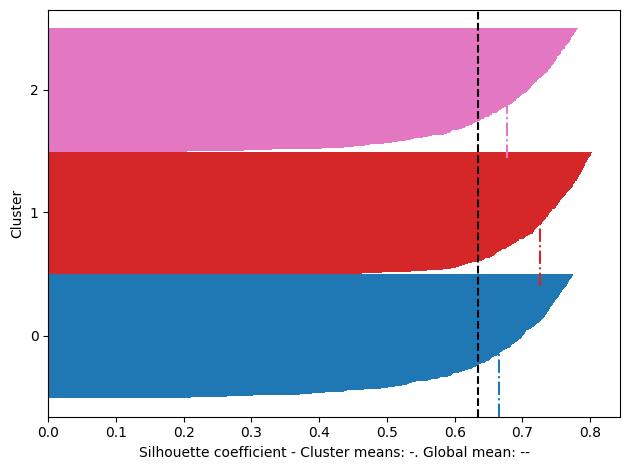

In [33]:
silhouette = silhouette_samples(X,y_db)
# from plot_silhouette import plot_silhouette  # python script provided separately
from plot_silhouette_w_mean import plot_silhouette  # python script provided separately
plot_silhouette(silhouette,y_db)